/var/folders/m2/xxfzg66d7d72n8x4mh4qjctr0000gn/T/ipykernel_30369/3875554284.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['INSTALL_YEAR'] = df_valid['INSTALL_DATE'].dt.year


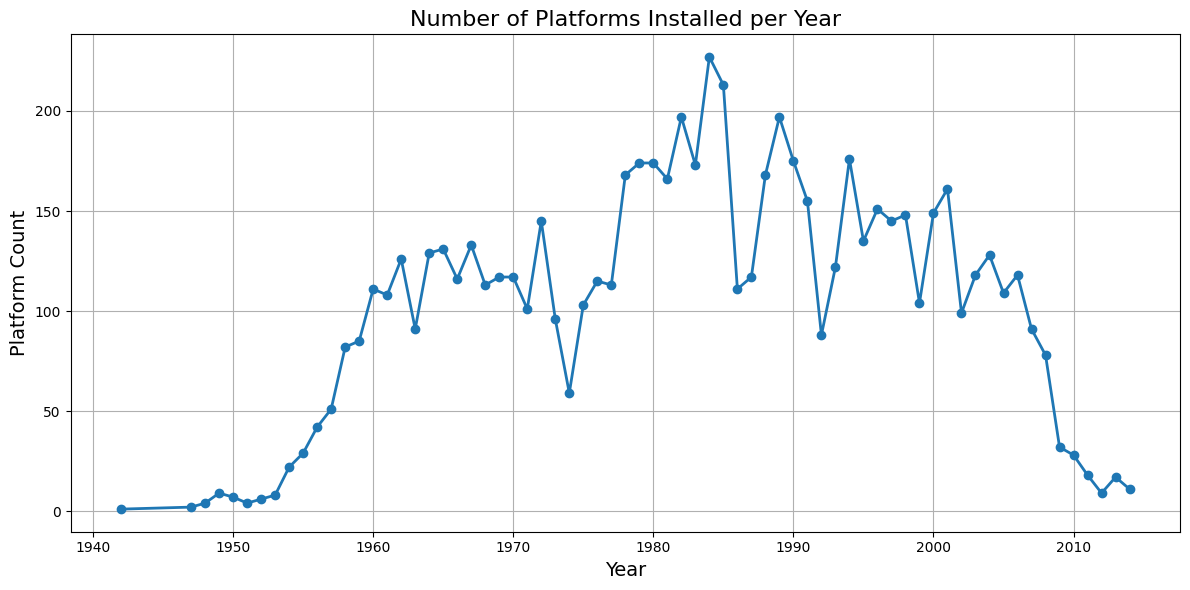

<Figure size 1400x700 with 0 Axes>

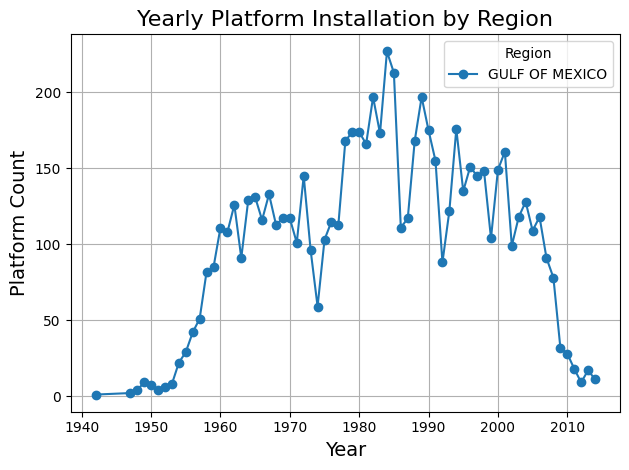

<Figure size 1400x700 with 0 Axes>

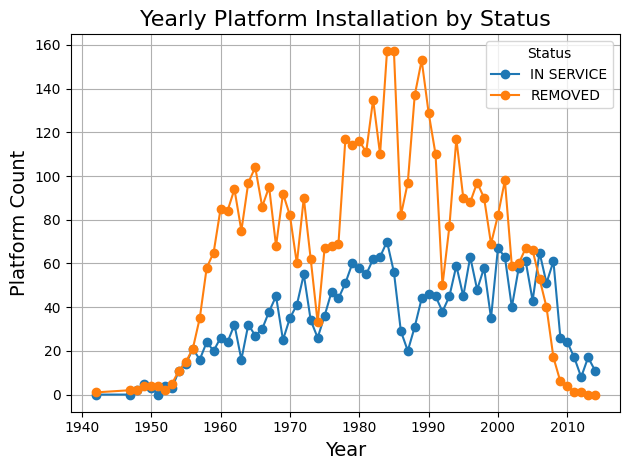

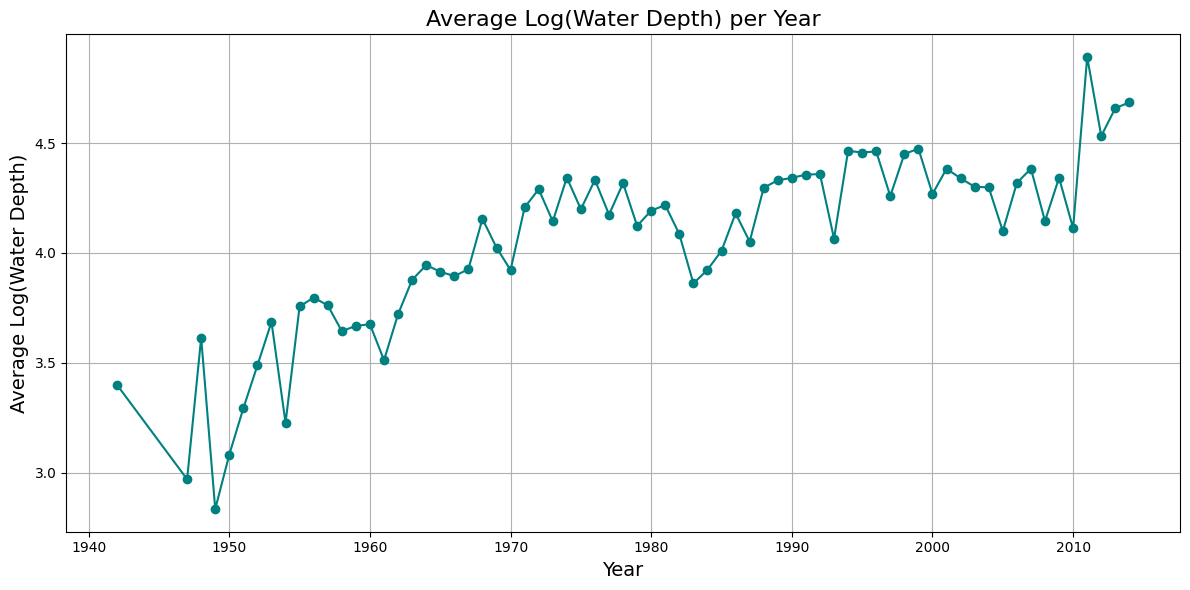

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("../data/platforms_logdepth.csv")

# -----------------------------
# Data Preprocessing
# -----------------------------
# Convert INSTALL column to datetime
df['INSTALL_DATE'] = pd.to_datetime(df['INSTALL'], errors='coerce')

# Drop records with invalid dates
df_valid = df.dropna(subset=['INSTALL_DATE'])

# Extract year from date
df_valid['INSTALL_YEAR'] = df_valid['INSTALL_DATE'].dt.year

# Filter reasonable year range (1940–2025)
df_valid = df_valid[(df_valid['INSTALL_YEAR'] > 1940) & (df_valid['INSTALL_YEAR'] <= 2025)]

# -----------------------------
# Installation count per year
# -----------------------------
install_counts = df_valid['INSTALL_YEAR'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(install_counts.index, install_counts.values, marker='o', linewidth=2)
plt.title("Number of Platforms Installed per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Platform Count", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/plot_installation_count_per_year.png")
plt.show()

# -----------------------------
# Installations by Region per Year
# -----------------------------
region_year_group = df_valid.groupby(['INSTALL_YEAR', 'REGION']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
region_year_group.plot(kind='line', marker='o')
plt.title("Yearly Platform Installation by Region", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Platform Count", fontsize=14)
plt.grid(True)
plt.legend(title='Region', fontsize=10)
plt.tight_layout()
plt.savefig("../data/plot_installation_by_region.png")
plt.show()

# -----------------------------
# Installations by Status per Year
# -----------------------------
status_year_group = df_valid.groupby(['INSTALL_YEAR', 'STATUS']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
status_year_group.plot(kind='line', marker='o')
plt.title("Yearly Platform Installation by Status", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Platform Count", fontsize=14)
plt.grid(True)
plt.legend(title='Status', fontsize=10)
plt.tight_layout()
plt.savefig("../data/plot_installation_by_status.png")
plt.show()

# -----------------------------
# Average LOG_WDEPTH per Year
# -----------------------------
avg_logdepth_per_year = df_valid.groupby('INSTALL_YEAR')['LOG_WDEPTH'].mean()

plt.figure(figsize=(12, 6))
plt.plot(avg_logdepth_per_year.index, avg_logdepth_per_year.values, marker='o', color='teal')
plt.title("Average Log(Water Depth) per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Log(Water Depth)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/plot_avg_logdepth_per_year.png")
plt.show()


In [3]:
df_valid.to_csv("../data/platforms_cleaned.csv", index=False)


In [4]:
! pip install pykrige



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


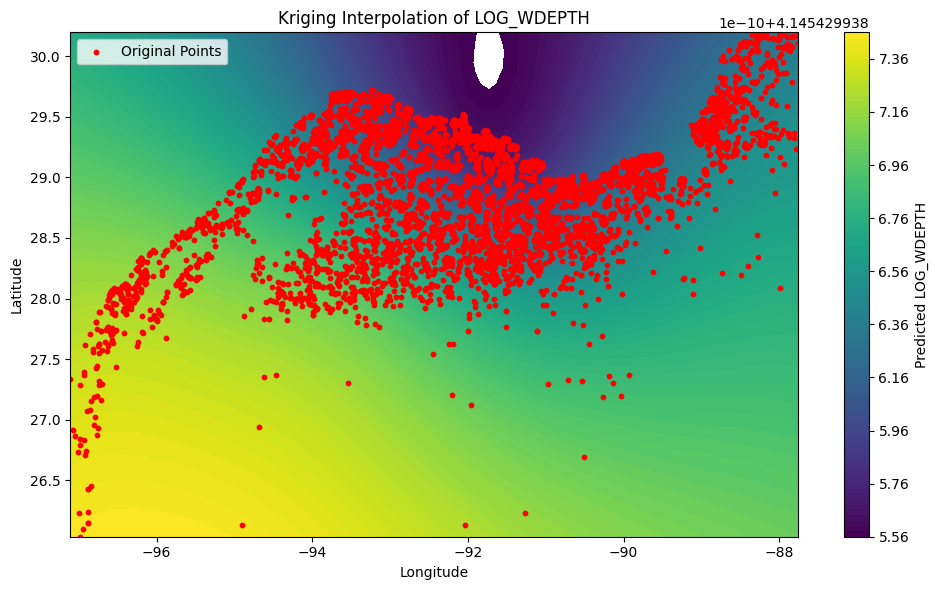

In [7]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

# Step 1: Load Data
# Replace 'platforms_cleaned.csv' with your file path if needed
df = pd.read_csv('../data/platforms_cleaned.csv')

# Step 2: Drop Missing Values (if any)
df = df.dropna(subset=['LONGITUDE', 'LATITUDE', 'LOG_WDEPTH'])

# Step 3: Extract Coordinates and Variable
x = df['LONGITUDE'].values
y = df['LATITUDE'].values
z = df['LOG_WDEPTH'].values

# Step 4: Create Grid for Interpolation (Adjust resolution as needed)
grid_lon = np.linspace(x.min(), x.max(), 100)
grid_lat = np.linspace(y.min(), y.max(), 100)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

# Step 5: Kriging Interpolation
OK = OrdinaryKriging(
    x, y, z,
    variogram_model='linear',  # You can try 'spherical', 'exponential', 'gaussian'
    verbose=False,
    enable_plotting=False
)

# Interpolate onto the grid
z_pred, ss = OK.execute('grid', grid_lon, grid_lat)

# Step 6: Visualize Interpolated Surface
plt.figure(figsize=(10, 6))
plt.contourf(grid_x, grid_y, z_pred, cmap='viridis', levels=100)
plt.colorbar(label='Predicted LOG_WDEPTH')
plt.scatter(x, y, c='red', s=10, label='Original Points')
plt.title('Kriging Interpolation of LOG_WDEPTH')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.tight_layout()
plt.savefig('kriging_result.png', dpi=300)
plt.show()


exponential Kriging: 100%|██████████| 10/10 [01:04<00:00,  6.47s/it]



Kriging Model Comparison (10-Fold Cross Validation):
         model      rmse  mean_error  std_error
3    spherical  0.196482   -0.003509   0.196450
2     gaussian  0.345437   -0.002962   0.345425
4  exponential  0.388301   -0.006705   0.388243
1        power  0.932349   -0.013877   0.932245
0       linear  0.932349   -0.013877   0.932245


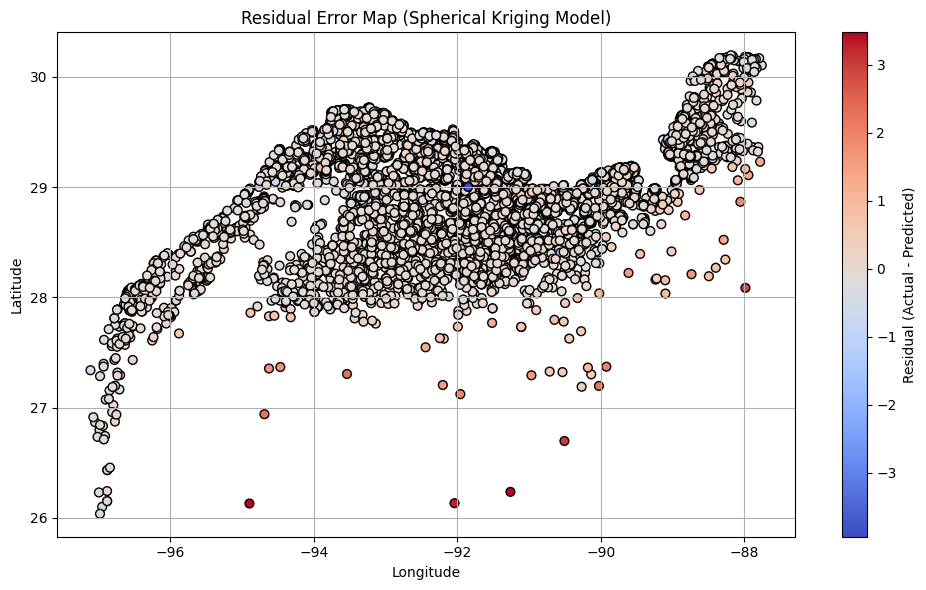

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Load and clean dataset
df = pd.read_csv('../data/platforms_cleaned.csv')
df = df.dropna(subset=['LONGITUDE', 'LATITUDE', 'LOG_WDEPTH'])

# Extract coordinates and depth values
x = df['LONGITUDE'].values
y = df['LATITUDE'].values
z = df['LOG_WDEPTH'].values

# Define variogram models to test
variogram_models = ['linear', 'power', 'gaussian', 'spherical', 'exponential']
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store performance metrics and residuals
evaluation_results = []
residuals_map_data = []

# Loop over each variogram model
for model in variogram_models:
    actual_all = []
    predicted_all = []
    residual_map = []

    # Perform 10-fold CV
    for train_idx, test_idx in tqdm(kf.split(x), total=10, desc=f'{model} Kriging'):
        x_train, y_train, z_train = x[train_idx], y[train_idx], z[train_idx]
        x_test, y_test = x[test_idx], y[test_idx]

        try:
            OK = OrdinaryKriging(
                x_train, y_train, z_train,
                variogram_model=model,
                verbose=False,
                enable_plotting=False
            )
            z_pred, _ = OK.execute('points', x_test, y_test)
            actual_all.extend(z[test_idx])
            predicted_all.extend(z_pred)
            residual_map.extend(zip(x[test_idx], y[test_idx], z[test_idx] - z_pred))
        except Exception as e:
            print(f"Error with model {model}: {e}")
            continue

    # Compute metrics
    actual_all = np.array(actual_all)
    predicted_all = np.array(predicted_all)
    rmse = np.sqrt(mean_squared_error(actual_all, predicted_all))
    mean_err = np.mean(predicted_all - actual_all)
    std_err = np.std(predicted_all - actual_all)

    evaluation_results.append({
        'model': model,
        'rmse': rmse,
        'mean_error': mean_err,
        'std_error': std_err
    })

    # Save residuals of selected model for visualization
    if model == 'spherical':
        residuals_map_data = residual_map

# Show evaluation table
eval_df = pd.DataFrame(evaluation_results)
eval_df.sort_values(by='rmse', inplace=True)
print("\nKriging Model Comparison (10-Fold Cross Validation):")
print(eval_df)

# Plot residuals map for 'spherical' model
residuals_map_data = np.array(residuals_map_data)
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    residuals_map_data[:, 0], residuals_map_data[:, 1],
    c=residuals_map_data[:, 2], cmap='coolwarm', edgecolor='k', s=40
)
plt.colorbar(sc, label='Residual (Actual - Predicted)')
plt.title('Residual Error Map (Spherical Kriging Model)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.savefig("residual_map_spherical.png", dpi=300)
plt.show()
